In [38]:
#@title
######################################################
# Import libraries
######################################################

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sklearn
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate

import pickle
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 170)

In [13]:
#@title
######################################################
# Helper Methods
######################################################

def load_dataset(filename, extension='.csv'):
    """
    Iports the dataset
    Parameters
    ----------
    dataset

    Returns
    -------
    dataframe
    """
    if 'csv' in extension:
        data = pd.read_csv(filename+extension)
    elif 'xls' in extension:
        data = pd.read_excel(filename+extension)
    elif 'pkl' in extension:
        data = pd.DataFrame(pickle.load(open(filename+extension, 'rb')))
    return data

def save_dataset(data, filename, extension='.csv'):
    """
    Iports the dataset
    Parameters
    ----------
    dataset

    Returns
    -------
    dataframe
    """
    if 'csv' in extension:
        data.to_csv(filename+extension)
    elif 'xls' in extension:
        data.to_excel(filename+extension, index=False)
    elif 'pkl' in extension:
        pickle.dump(data, open(filename+extension, 'wb'))

def check_df(dataframe, head=5):
    """
    Prints out the shape, types, head, missing values and quantiles of the dataframe
    Parameters
    ----------
    dataframe
    head

    Returns
    -------
    No return
    """
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("################ Missing Values ################")
    print(dataframe.isnull().sum())

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Determines the categorical, numerical and categorical but cardinal columns.

    Parameters
    ------
        dataframe: dataframe
                dataframe whihc inludes the columns
        cat_th: int, optional
                class threshold valuse for determining numeric but categorical variable
        car_th: int, optional
                class threshold valuse for determining categoric but cardinal variable

    Returns
    ------
        cat_cols: list
                categorical columns
        num_cols: list
                numerical columns
        cat_but_car: list
                categoric but cardinal columns

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total columns
        cat_cols = all_cat_cols + num_but_cat - cat_but_car
        num_cols = all_num_cols - num_but_cat
    """

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")

    # cat cols
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    print(f'init cat_cols: {len(cat_cols)}')

    # num cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    print(f'init num_cols: {len(num_cols)}')

    # num but cat cols
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    print(f'num_but_cat: {len(num_but_cat)}')

    # cat but car cols
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    print(f'cat_but_car: {len(cat_but_car)}')

    # cat cols
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    print(f'final cat_cols: {len(cat_cols)}')

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f'final num_cols: {len(num_cols)}')

    return cat_cols, num_cols, cat_but_car

def new_feature_interval(dataframe, col, interval_value, header="new"):
    if header == "new":
        new_col = "new_" + col
    else:
        new_col = header
    for intrvl, val in interval_value.items():
        dataframe.loc[[var in intrvl for var in dataframe[col]], new_col] = val

def cat_cols_summary(dataframe, cat_cols, plot=False):
    """
    Ratio of the categorical classes in a column
    Parameters
    ----------
    dataframe
    col_name
    plot

    Returns
    -------
    No return
    """
    print("############## Frequency and Ratio #############")
    print(pd.DataFrame({"Freq": dataframe[cat_cols].value_counts(),
                        "Ratio": 100 * dataframe[cat_cols].value_counts() / len(dataframe)}).rename_axis(cat_cols))

    if plot:
        for col in cat_cols:
            sns.countplot(x=dataframe[col], data=dataframe)
            plt.show()

def num_cols_summary(dataframe, num_cols, plot=False):
    """
    Numerical variable exploration
    Parameters
    ----------
    dataframe
    numerical_col
    plot

    Returns
    -------
    No return
    """
    print("################### Describe ###################")
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40,
                 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[num_cols].describe(quantiles).T)

    if plot:
        for col in num_cols:
            dataframe[col].hist(bins=20)
            plt.xlabel(col)
            plt.title(col)
            plt.show()

def target_vs_cat_cols_summary(dataframe, target, cat_col):
    """
    Prints out the target mean of the categorical classes
    Parameters
    ----------
    dataframe
    target
    categorical_col

    Returns
    -------
    No return
    """
    print(pd.DataFrame(
        {target+"_MEAN": dataframe.groupby(cat_col).agg({target: "mean"})[target]}), end="\n\n\n")

def target_vs_num_cols_summary(dataframe, target, num_col):
    """
    Prints out the defined numeric variable mean of the target classes
    Parameters
    ----------
    dataframe
    target
    num_col

    Returns
    -------
    No return
    """
    print(pd.DataFrame(
        {num_col+"_MEAN": dataframe.groupby(target).agg({num_col: "mean"})[num_col]}), end="\n\n\n")

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    """
    Appoints the lower and upper thresholds by use of quantile
    Parameters
    ----------
    dataframe
    col_name
    q1: first quantile percentage
    q3: third quantile percentage

    Returns
    -------
    low_limit and up_limit thresholds as tupple
    """
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name, q1=0.05, q3=0.95):
    """
    Checks if there is an outlier and return bool value
    Parameters
    ----------
    dataframe
    col_name

    Returns
    -------
    outlier existance as bool
    """
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def one_hot_encoder(dataframe, cat_cols, drop_first=False, dummy_na=False):
    """
    Encodes the column of the dataframe with binary labels
    Parameters
    ----------
    dataframe
    categorical_cols
    drop_first

    Returns
    -------
    The one-hot encoded columns added dataframe
    """
    dataframe = pd.get_dummies(
        dataframe, columns=cat_cols, drop_first=drop_first, dummy_na=dummy_na)
    return dataframe

def robust_scaling(dataframe, col_name):
    """
    Scale features using statistics that are robust to outliers.
    This Scaler removes the median and scales the data according to the quantile range (defaults to IQR)
    Parameters
    ----------
    dataframe
    col_name

    Returns
    -------
    Robust scaled dataframe
    """
    rs = RobustScaler()
    dataframe[col_name] = rs.fit_transform(dataframe[[col_name]])
    return dataframe

def robust_scaling(dataframe, col_name):
    """
    Scale features using statistics that are robust to outliers.
    This Scaler removes the median and scales the data according to the quantile range (defaults to IQR)
    Parameters
    ----------
    dataframe
    col_name

    Returns
    -------
    Robust scaled dataframe
    """
    rs = RobustScaler()
    dataframe[col_name] = rs.fit_transform(dataframe[[col_name]])
    return dataframe


In [14]:
######################################################
# Load Data Set
######################################################

url = "https://raw.githubusercontent.com/atacanozkan/health_insurance_cost_prediction/main/insurance"
df = load_dataset(url)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.924
1,18,male,33.770,1,no,southeast,1725.552
2,28,male,33.000,3,no,southeast,4449.462
3,33,male,22.705,0,no,northwest,21984.471
4,32,male,28.880,0,no,northwest,3866.855


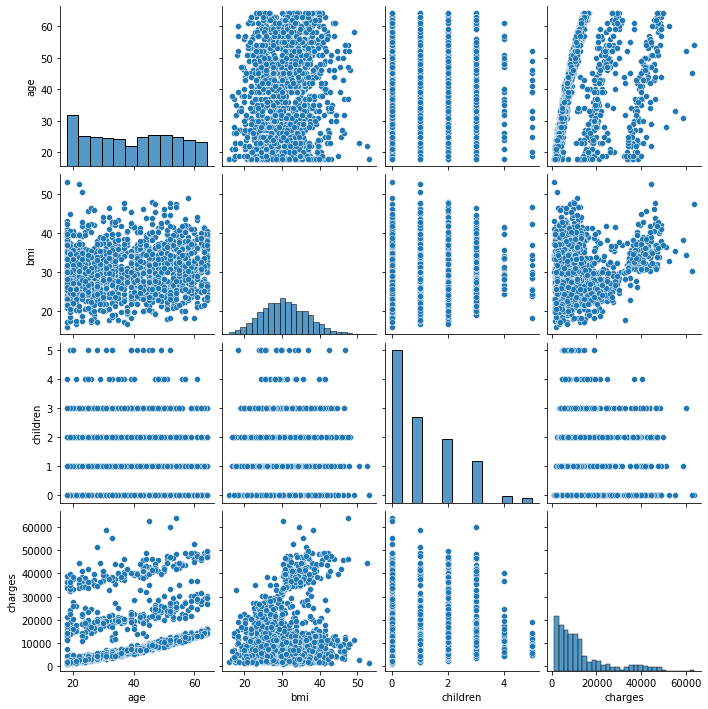

In [5]:
##########################
# Visualization
##########################
sns.pairplot(df)
plt.show()

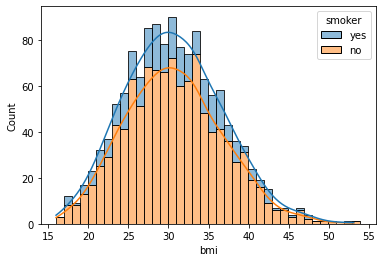

In [70]:
sns.histplot(data=df, x="bmi", hue="smoker", kde=True, binwidth=1, stat="count", multiple="stack")

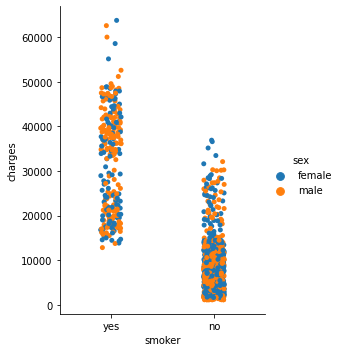

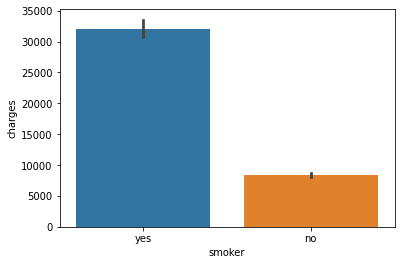

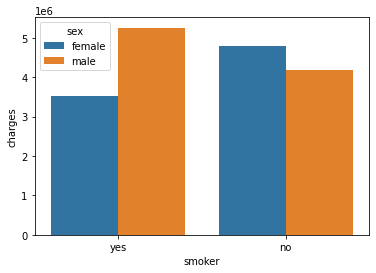

In [88]:
sns.catplot(x="smoker", y="charges", hue = 'sex', data=df, height=5, aspect=.8)
plt.show()
sns.barplot(x="smoker", y="charges", data=df)
plt.show()
sns.barplot(x="smoker", y="charges", hue = 'sex', data=df, ci=None, estimator=sum)
plt.show()

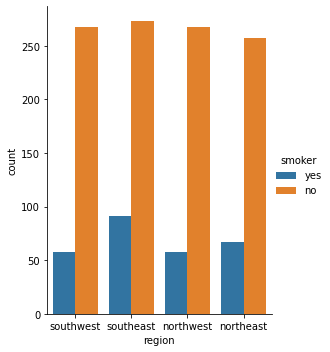

In [39]:
sns.catplot(x="region", kind="count", hue = 'smoker', data=df, height=5, aspect=.8)
plt.show()

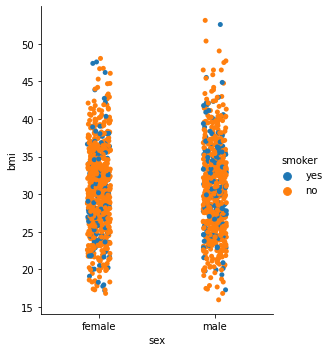

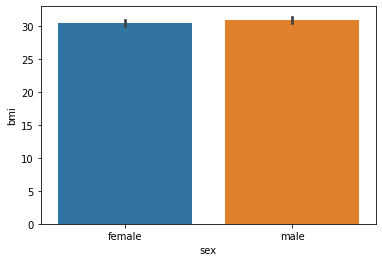

In [54]:
sns.catplot(x="sex", y="bmi", hue = 'smoker', data=df, height=5, aspect=.8)
plt.show()
sns.barplot(x="sex", y="bmi", data=df)
plt.show()

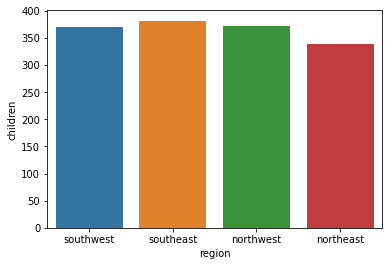

,count
region,
southeast,364
northwest,325
southwest,325
northeast,324


In [68]:
sns.barplot(x="region", y="children", data=df, ci=None, estimator=sum)
plt.show()
df.groupby('region').agg(['count'])['children'].sort_values(by='count', ascending=False)

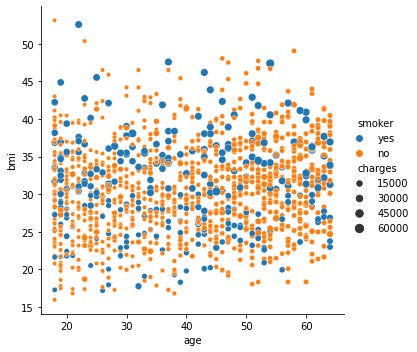

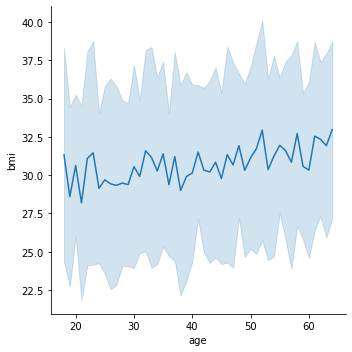

In [86]:
sns.relplot(x="age", y="bmi", size="charges", hue="smoker", data=df);
sns.relplot(x="age", y="bmi", kind="line", ci="sd", data=df);

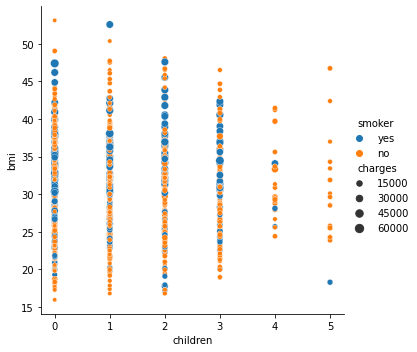

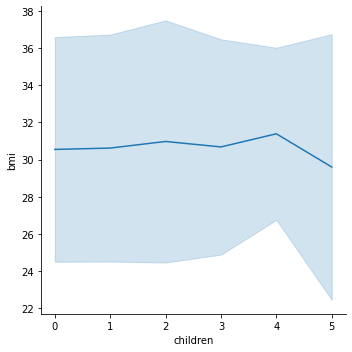

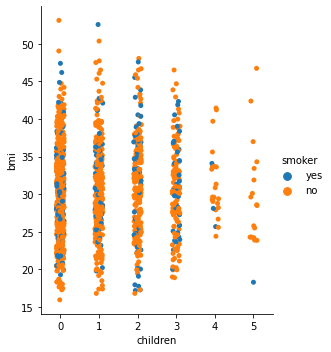

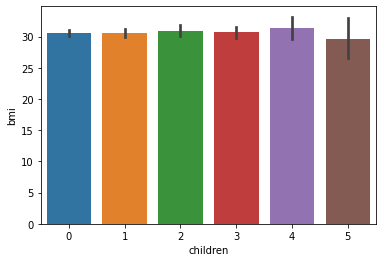

In [90]:
sns.relplot(x="children", y="bmi", size="charges", hue="smoker", data=df);
sns.relplot(x="children", y="bmi", kind="line", ci="sd", data=df);

sns.catplot(x="children", y="bmi", hue = 'smoker', data=df, height=5, aspect=.8)
plt.show()
sns.barplot(x="children", y="bmi", data=df)
plt.show()

In [15]:
######################################################
# Exploratory Data Analysis
######################################################

# Summary statistics of the dataframe
check_df(df, 5)
df.describe()

# Defining the categorical and numerical variables
print("")
cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols.append(cat_cols.pop(cat_cols.index('children')))
check_df(df, 5)

##################### Shape #####################
(1338, 7)
##################### Types #####################
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object
##################### Head #####################
   age     sex    bmi  children smoker     region   charges
0   19  female 27.900         0    yes  southwest 16884.924
1   18    male 33.770         1     no  southeast  1725.552
2   28    male 33.000         3     no  southeast  4449.462
3   33    male 22.705         0     no  northwest 21984.471
4   32    male 28.880         0     no  northwest  3866.855
##################### Tail #####################
      age     sex    bmi  children smoker     region   charges
1333   50    male 30.970         3     no  northwest 10600.548
1334   18  female 31.920         0     no  northeast  2205.981
1335   18  female 36.850         0     no  southeast  1629.833
1336   21  female 25.800  

In [16]:
######################################################
# Feature Engineering
######################################################
new_feature_interval(df, 'age',
                   {
                    pd.Interval(-np.inf, 18, closed='neither'):'young',
                    pd.Interval(18, 44, closed='left'):'mature',
                    pd.Interval(44, 64, closed='left'):'senior',
                    pd.Interval(64, np.inf, closed='left'):'old'
                   }
                   )

df['bmi_age'] = df['bmi']/df['age']

# Defining the categorical and numerical variables
print("")
cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols.append(cat_cols.pop(cat_cols.index('children')))

# Summary statistics of the dataframe
check_df(df, 5)


Observations: 1338
Variables: 9
init cat_cols: 4
init num_cols: 5
num_but_cat: 1
cat_but_car: 0
final cat_cols: 5
final num_cols: 4
##################### Shape #####################
(1338, 9)
##################### Types #####################
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
new_age      object
bmi_age     float64
dtype: object
##################### Head #####################
   age     sex    bmi  children smoker     region   charges new_age  bmi_age
0   19  female 27.900         0    yes  southwest 16884.924  mature    1.468
1   18    male 33.770         1     no  southeast  1725.552  mature    1.876
2   28    male 33.000         3     no  southeast  4449.462  mature    1.179
3   33    male 22.705         0     no  northwest 21984.471  mature    0.688
4   32    male 28.880         0     no  northwest  3866.855  mature    0.902
##################### Tail #####################
   

In [8]:
##########################
# Target Analysis
##########################

num_cols_summary(df, 'charges', False)

################### Describe ###################
count    1338.000
mean    13270.422
std     12110.011
min      1121.874
5%       1757.753
10%      2346.534
20%      3991.576
30%      5484.847
40%      7369.053
50%      9382.033
60%     11399.857
70%     13767.875
80%     20260.626
90%     34831.720
95%     41181.828
99%     48537.481
max     63770.428
Name: charges, dtype: float64


In [9]:
##########################
# Feature Analysis
##########################

# Summary statistics of all numerical variables
num_cols_summary(df, num_cols, False)

# Summary statistics of all categorical variables
print()
cat_cols_summary(df, cat_cols)

################### Describe ###################
            count      mean       std      min       5%      10%      20%      30%      40%      50%       60%       70%       80%       90%       95%       99%  \
age      1338.000    39.207    14.050   18.000   18.000   19.000   24.000   29.000   34.000   39.000    44.000    49.000    54.000    59.000    62.000    64.000   
bmi      1338.000    30.663     6.098   15.960   21.256   22.990   25.326   27.360   28.797   30.400    32.032    33.660    35.860    38.619    41.106    46.408   
charges  1338.000 13270.422 12110.011 1121.874 1757.753 2346.534 3991.576 5484.847 7369.053 9382.033 11399.857 13767.875 20260.626 34831.720 41181.828 48537.481   
bmi_age  1338.000     0.902     0.409    0.306    0.448    0.497    0.567    0.625    0.700    0.781     0.885     1.037     1.222     1.516     1.733     2.142   
children 1338.000     1.095     1.205    0.000    0.000    0.000    0.000    0.000    0.000    1.000     1.000     2.000     2.000 

In [10]:
##########################
# Target vs Features Analysis
##########################

target_vs_cat_cols_summary(df, "charges", cat_cols)
for col in cat_cols:
    target_vs_cat_cols_summary(df, "charges", col)

                                 charges_MEAN
sex    smoker region    new_age              
female no     northeast mature       6835.573
                        old         15485.301
                        senior      13138.095
              northwest mature       6020.818
                        old         15574.189
...                                       ...
male   yes    southeast mature      32424.749
                        old         41131.146
                        senior      41485.842
              southwest mature      31068.157
                        senior      36731.767

[44 rows x 1 columns]


        charges_MEAN
sex                 
female     12569.579
male       13956.751


        charges_MEAN
smoker              
no          8434.268
yes        32050.232


           charges_MEAN
region                 
northeast     13406.385
northwest     12417.575
southeast     14735.411
southwest     12346.937


         charges_MEAN
new_age              
mature      106

In [17]:
######################################################
# Data Preprocessing
######################################################

# Missing value analysis:
print(df.isnull().sum())

# Outlier analysis:
print()
for col in num_cols:
    print(col, check_outlier(df, col))

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
new_age     0
bmi_age     0
dtype: int64

age False
bmi False
charges False
bmi_age False
children False


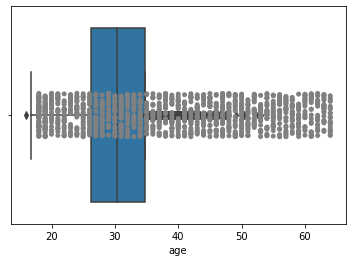

In [12]:
ax = sns.boxplot(x="bmi", data=df, whis=[0.05, 0.95])
sns.stripplot(x="age", data=df, color=".5")

In [13]:
cat_cols

['sex', 'smoker', 'region', 'new_age']

In [18]:
#############################################
# One-Hot Encoding
#############################################
df = one_hot_encoder(df, cat_cols)
check_df(df)

##################### Shape #####################
(1338, 16)
##################### Types #####################
age                   int64
bmi                 float64
children              int64
charges             float64
bmi_age             float64
sex_female            uint8
sex_male              uint8
smoker_no             uint8
smoker_yes            uint8
region_northeast      uint8
region_northwest      uint8
region_southeast      uint8
region_southwest      uint8
new_age_mature        uint8
new_age_old           uint8
new_age_senior        uint8
dtype: object
##################### Head #####################
   age    bmi  children   charges  bmi_age  sex_female  sex_male  smoker_no  smoker_yes  region_northeast  region_northwest  region_southeast  region_southwest  \
0   19 27.900         0 16884.924    1.468           1         0          0           1                 0                 0                 0                 1   
1   18 33.770         1  1725.552    1.876          

In [15]:
num_cols

['age', 'bmi', 'charges', 'bmi_age', 'children']

In [19]:
#############################################
# Feature Scaling
#############################################
for col in num_cols:
  df = robust_scaling(df, col)

df.head()

,age,bmi,children,charges,bmi_age,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,new_age_mature,new_age_old,new_age_senior
0,-0.833,-0.298,-0.500,0.631,1.320,1,0,0,1,0,0,0,1,1,0,0
1,-0.875,0.401,0.000,-0.643,2.103,0,1,1,0,0,0,1,0,1,0,0
2,-0.458,0.310,1.000,-0.415,0.763,0,1,1,0,0,0,1,0,1,0,0
3,-0.250,-0.916,-0.500,1.059,-0.179,0,1,1,0,0,1,0,0,1,0,0
4,-0.292,-0.181,-0.500,-0.463,0.233,0,1,1,0,0,1,0,0,1,0,0


In [20]:
dff = df.copy()
dff.head()

,age,bmi,children,charges,bmi_age,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,new_age_mature,new_age_old,new_age_senior
0,-0.833,-0.298,-0.500,0.631,1.320,1,0,0,1,0,0,0,1,1,0,0
1,-0.875,0.401,0.000,-0.643,2.103,0,1,1,0,0,0,1,0,1,0,0
2,-0.458,0.310,1.000,-0.415,0.763,0,1,1,0,0,0,1,0,1,0,0
3,-0.250,-0.916,-0.500,1.059,-0.179,0,1,1,0,0,1,0,0,1,0,0
4,-0.292,-0.181,-0.500,-0.463,0.233,0,1,1,0,0,1,0,0,1,0,0


In [21]:
#######################################
# Data Preparation for Model
#######################################

y = dff["charges"]
X = dff.drop(["charges"], axis=1)

In [39]:
######################################################
# Base Models
######################################################

models = [('SVR', SVR()),
          ('LR', LinearRegression()),
          ('RF', RandomForestRegressor()),
          ("CART", DecisionTreeRegressor()),
          ("LightGBM", LGBMRegressor())]

for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 0.4036 (SVR) 
RMSE: 0.5096 (LR) 
RMSE: 0.4026 (RF) 
RMSE: 0.5288 (CART) 
RMSE: 0.4001 (LightGBM) 


In [47]:
######################################################
# Automated Hyperparameter Optimization
######################################################

svr_params = {'C': [0.1, 1, 10], 
              'gamma': [1,0.1,0.01],
              'kernel': ['rbf', 'sigmoid']}

rf_params = {"max_depth": [5, 8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [8, 15, 20],
             "n_estimators": [200, 500, 1000]}

cart_params = {'max_depth': [1, 10],
               "min_samples_split": [2, 30]}

lightgbm_params = {"learning_rate": [0.01, 0.1, 0.001],
                   "n_estimators": [300, 500, 1500],
                   "colsample_bytree": [0.5, 0.7, 1]}

regressors = [("SVR", SVR(), svr_params),
              ("RF", RandomForestRegressor(), rf_params),
              ("CART", DecisionTreeRegressor(), cart_params),
              ('LightGBM', LGBMRegressor(), lightgbm_params)]

best_models = {}

for name, regressor, params in regressors:
    print(f"########## {name} ##########")
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

    gs_best = GridSearchCV(regressor, params, cv=3, n_jobs=-1, verbose=False).fit(X, y)

    final_model = regressor.set_params(**gs_best.best_params_)
    rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE (After): {round(rmse, 4)} ({name}) ")

    print(f"{name} best params: {gs_best.best_params_}", end="\n\n")

    best_models[name] = final_model

########## SVR ##########
RMSE: 0.4036 (SVR) 
RMSE (After): 0.3996 (SVR) 
SVR best params: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

########## RF ##########
RMSE: 0.4004 (RF) 
RMSE (After): 0.3787 (RF) 
RF best params: {'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 15, 'n_estimators': 200}

########## CART ##########
RMSE: 0.5413 (CART) 
RMSE (After): 0.4229 (CART) 
CART best params: {'max_depth': 10, 'min_samples_split': 30}

########## LightGBM ##########
RMSE: 0.4001 (LightGBM) 
RMSE (After): 0.3869 (LightGBM) 
LightGBM best params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'n_estimators': 500}



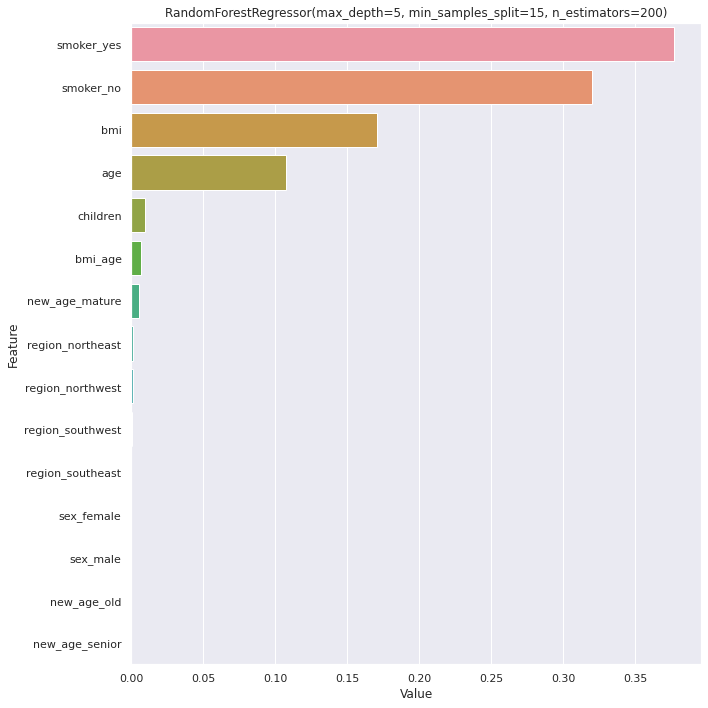

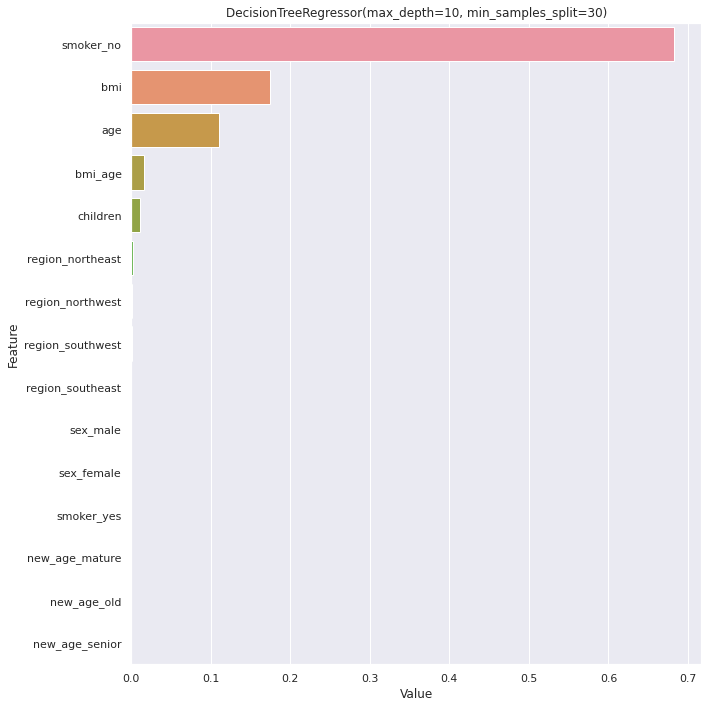

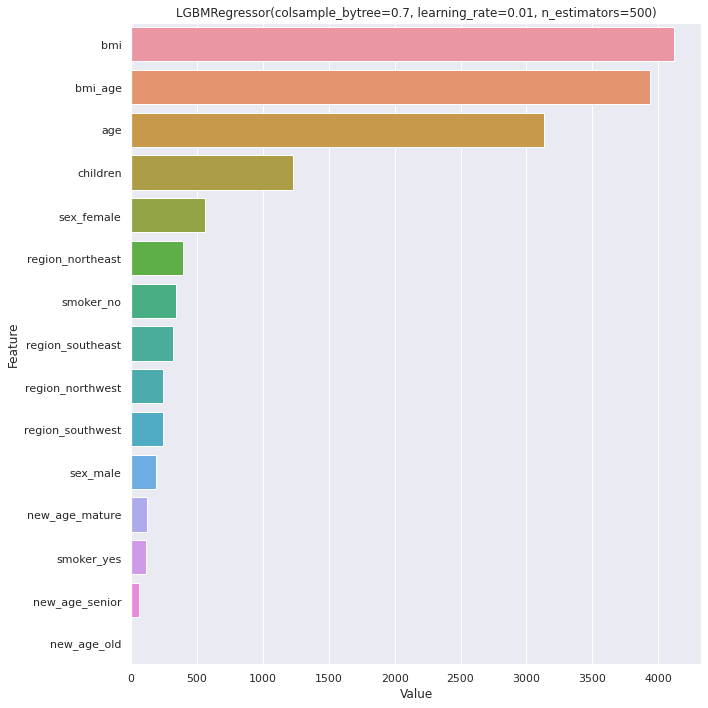

In [65]:
################################################
# Feature Importance
################################################

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title(str(model))
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

for name in ['RF','CART','LightGBM']:
  plot_importance(best_models[name].fit(X, y), X)